##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

This tutorial shows how to classify images of building types using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [57]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [58]:
train_dir = "/content/drive/MyDrive/data/train"
val_dir   = "/content/drive/MyDrive/data/validation"

In [59]:
#Print out the class names in training directory
import pathlib
from PIL import Image
train_path = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in train_path.glob('*')]))
print(class_names)

['cat10 StripMall' 'cat11 L_ShopMall' 'cat17 LowRise' 'cat18 MidRise'
 'cat19 HighRise' 'cat20 InstiBldg' 'cat21 MetalBldg' 'cat22 Canopy']


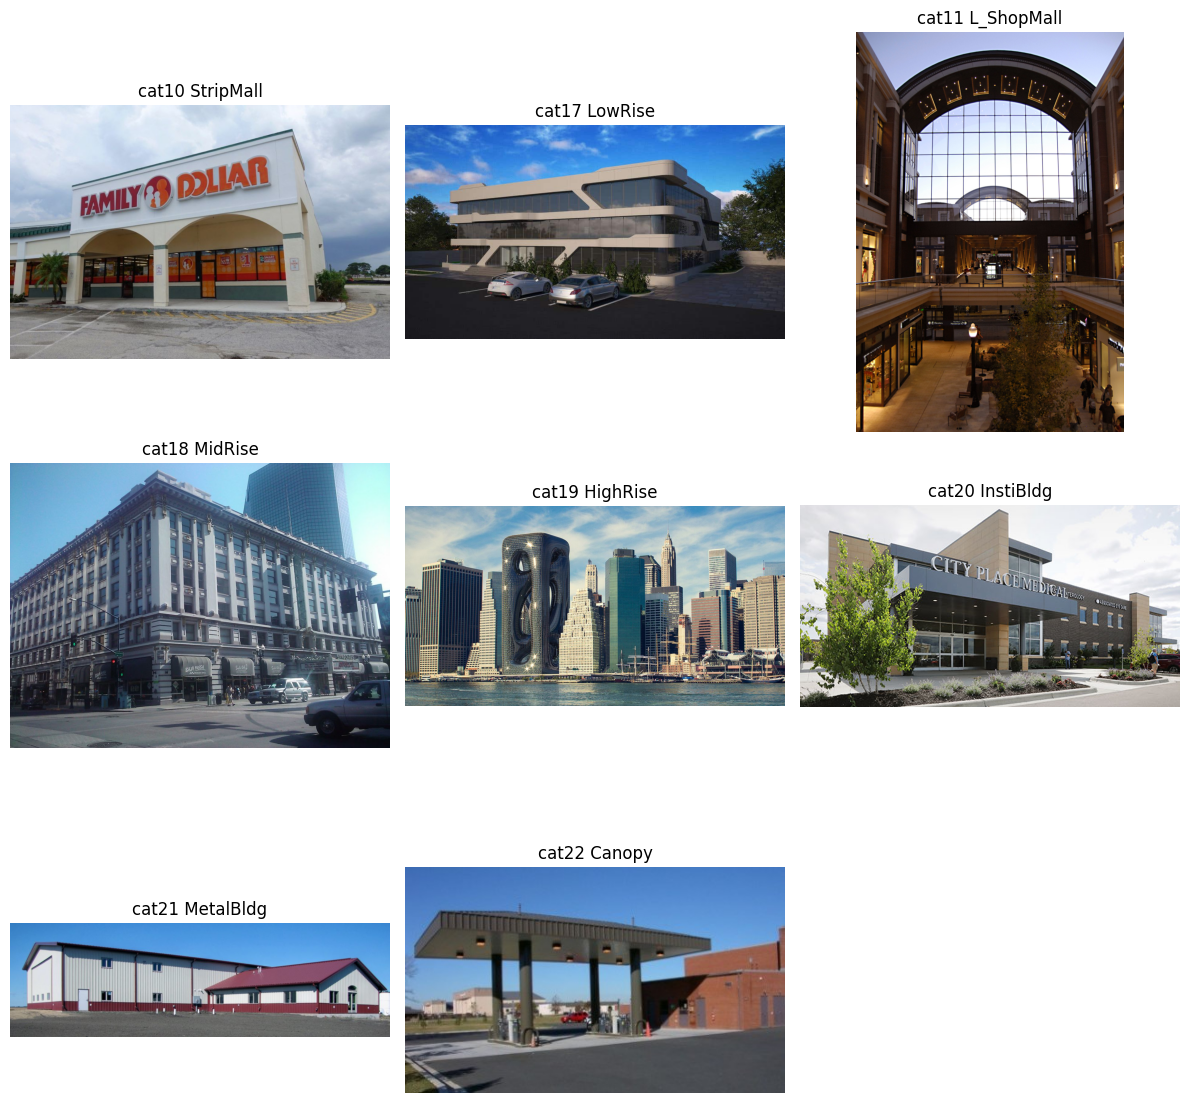

In [60]:
#Print one image per class (all 9 building categories) automatically in grid
class_folders = [f for f in train_path.iterdir() if f.is_dir()]

cols = 3
rows = (len(class_folders) + cols - 1) // cols
plt.figure(figsize=(12, 4 * rows))

for i, class_folder in enumerate(class_folders):
    first_img = list(class_folder.glob("*"))[0]
    img = Image.open(first_img)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_folder.name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [62]:
import tensorflow as tf

img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    # labels="inferred",        # reads folder names (cat07, cat08, ...)
    # label_mode="categorical", # one-hot encoded labels (good for multi-class)
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    # labels="inferred",
    # label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


Found 5179 files belonging to 8 classes.
Found 792 files belonging to 8 classes.


You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [76]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 9  # since you have 9 building types

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Show model summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,401 (24.59 MB)

 Trainable params: 6,447,401 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.2699 - loss: 2.1452 - val_accuracy: 0.4760 - val_loss: 1.5157
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5503 - loss: 1.3186 - val_accuracy: 0.5694 - val_loss: 1.2635
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6746 - loss: 0.9463 - val_accuracy: 0.6364 - val_loss: 1.1020
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8178 - loss: 0.5538 - val_accuracy: 0.6755 - val_loss: 1.0495
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9162 - loss: 0.3009 - val_accuracy: 0.6591 - val_loss: 1.2838
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9561 - loss: 0.1733 - val_accuracy: 0.6793 - val_loss: 1.2475
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9695 - loss: 0.1431 - val_accuracy: 0.6919 - val_loss: 1.3059
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9759 - loss: 0.1115 - val_acc

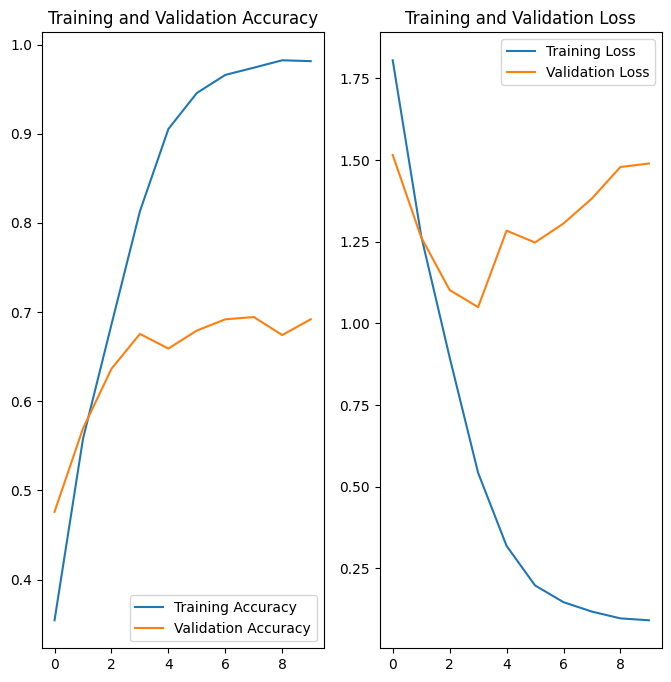

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [115]:
data_augmentation = keras.Sequential([
    # Slight horizontal flips (buildings can be mirrored)
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),

    # Small random rotations (±15 degrees)
    layers.RandomRotation(0.15),

    # Random zoom in/out
    layers.RandomZoom(0.15),

    # Random brightness changes (simulate lighting)
    layers.RandomContrast(0.2),

    # Optional: slight height/width shift
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05)
])

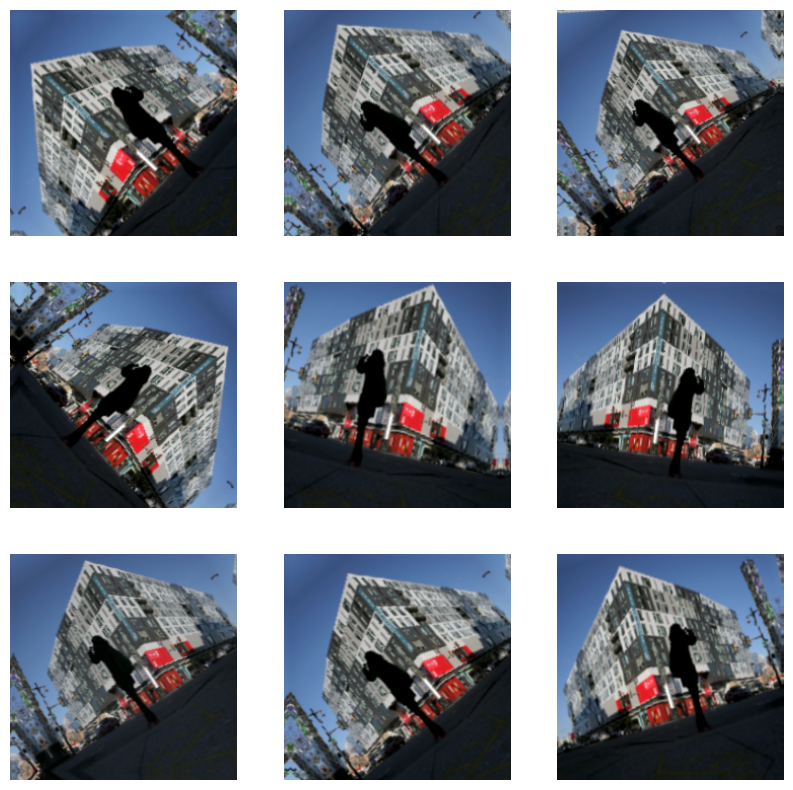

In [116]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [117]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),


  layers.Conv2D(128, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),

  layers.Dense(num_classes, activation='softmax', name="outputs")
])

In [118]:
# Compile the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Show model summary
model2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,041 (50.49 MB)

 Trainable params: 13,236,041 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:

epochs = 50
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)


Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.1804 - loss: 2.1407 - val_accuracy: 0.2626 - val_loss: 1.9006
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.2943 - loss: 1.8552 - val_accuracy: 0.3750 - val_loss: 1.6873
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.3950 - loss: 1.6451 - val_accuracy: 0.4306 - val_loss: 1.5228
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.4492 - loss: 1.4823 - val_accuracy: 0.4697 - val_loss: 1.3939
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.5074 - loss: 1.3544 - val_accuracy: 0.4836 - val_loss: 1.4384
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.5316 - loss: 1.3087 - val_accuracy: 0.5366 - val_loss: 1.2949
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.5305 - loss: 1.2775 - val_accuracy: 0.5758 - val_loss: 1.1989
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.5532 - loss: 1.210

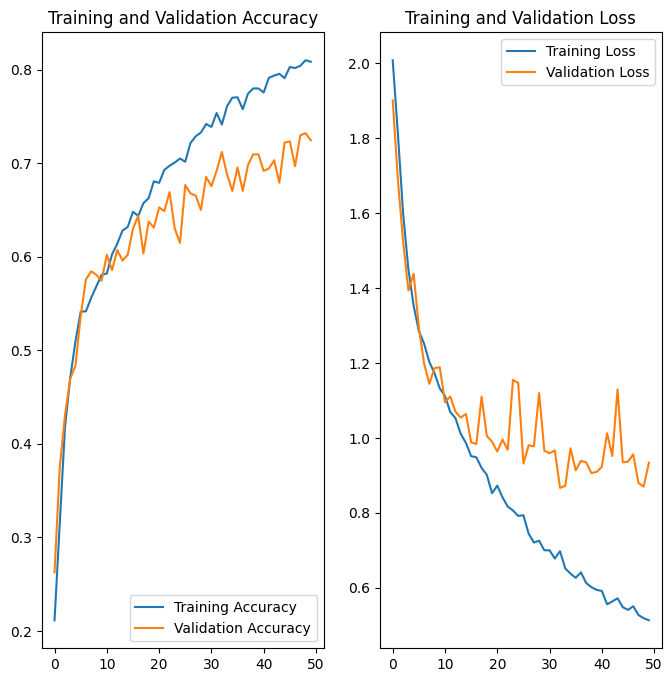

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [28]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
This image most likely belongs to sunflowers with a 99.91 percent confidence.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).